# 决策树

决策树的原理较为简单，表示起来和数据结构中的图没有什么区别。

## 决策树的构造

决策树的构造需要解决的第一个问题就是：如何选择划分的依据呢？即，如何选择划分数据分类的特征？  
《机器学习实战》中介绍了ID3算法--迭代二叉树3代。这个算法的核心思想是利用**信息增益**来度量属性的选择。

### 信息增益

首先需要知道两个定义。如果待分类的事务可能划分在多个类中（即该事务不属于同一个分类，这是决策树停止划分的条件），则：
1. xi的信息定义为**L(xi)=-log2p(xi)** 。其中，p(xi)为选择该分类的概率。
2. 熵 **H = -Σ(i=1~n)p(xi)log2p(xi)** 。   


根据这个公式写出计算香农熵的代码

In [1]:
# 计算熵
from math import log
def calShannonEnt(dataset):
    numEntries = len(dataset)  #数据总数
    labelCounts = {}  #计算各个分类的总量
    for i in dataset:
        currLabel = i[-1]  #获取当前标签
        if currLabel not in labelCounts:
            labelCounts[currLabel] = 0  
        labelCounts[currLabel]+=1   #统计标签出现次数
    shannonEnt = 0.0
    for i in labelCounts:
        prob = float(labelCounts[i])/numEntries
        shannonEnt -= prob * log(prob,2)  #按照公式计算
    return shannonEnt

In [2]:
#测试calShannonEnt函数
data = [[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']]
calShannonEnt(data)

0.9709505944546686

熵反映了一个数据集的无序程度。换句话说，熵越高，则混合的数据就越多。（浅显的理解就是分类越多熵越高）

### 划分数据集

1. 首先，先完成一个按照给定特征划分数据集的程序

In [3]:
# 按给定特征划分数据集
def splitDataSet(dataset,axis,value):  #dataset是数据集，axis是给定的特征，value是期望的该特征的值
    newDataSet = []
    for data in dataset:
        if data[axis] == value:  #如果该条数据的axis值等于value
            reducedData = data[:axis]  #去掉该特征
            reducedData.extend(data[axis+1:])  #以上两步实际上相当于pandas的drop
            newDataSet.append(reducedData)
    return newDataSet

#将上述data数据按照第0维特征划分
print(splitDataSet(data,0,0))  #第0维特征等于0
print(splitDataSet(data,0,1))  #第0维特征等于1

[[1, 'no'], [1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]


In [4]:
subdataset = [example[2] for example in data]
subdataset

['yes', 'yes', 'no', 'no', 'no']

2. 选择最佳的属性以划分数据集

In [5]:
# 选择最佳的属性以划分数据集
def chooseBestFeatureToSplit(dataset):
    numFeatures = len(dataset[0]) - 1  #计算特征维度
    baseEntropy = calShannonEnt(dataset)
    bestInfoGain = 0.0
    bestFeatrue = -1
    for i in range(numFeatures):
        featureList = [example[i] for example in dataset]  #对于每一个特征（i），取出其所有可能的取值
        featureSet = set(featureList)  #唯一化特征的取值
        newEntropy = 0.0
        for value in featureSet:
            splitdataset = splitDataSet(dataset,i,value)  #对于第i个特征，将其按照所有的取值value划分数据集
            prob = len(splitdataset)/float(len(dataset))  #计算取value时所占总数据集比例
            newEntropy += calShannonEnt(splitdataset) * prob 
            #计算新的香农熵，划分后的信息熵需要乘上每种划分的概率
            infoGain = baseEntropy - newEntropy  #计算信息受益
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i  #找到获得最高信息受益的特征
    return bestFeature

chooseBestFeatureToSplit(data)

0

3. 递归创建树

In [6]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote] +=1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

In [16]:
def createTree(dataset,labels):
    classlist = [example[-1] for example in dataset]   #获取当前数据集的所有类别
    if classlist.count(classlist[0]) == len(classlist):   #如果列表中第一个值(classlist[0])的个数等于列表长度，换言之，所有数据的分类相同
        return classlist[0]
    if len(dataset[0]) == 1:  #数据集的特征只剩下一个，换言之，所有特征都已使用完，并且还不能使数据集完全分类(因为没有触发第一个停止条件)
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataset)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    #这里开始就和之前的思路一样了，找出选择的最好特征值的所有取值，按每一个取值划分数据集。对于每一个划分后的子数据集，都重新构建一个子树。
    featLabels = [example[bestFeat] for example in dataset]
    uniqueVals = set(featLabels)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataset,bestFeat,value),subLabels)
    return myTree

In [10]:
labels = ['no surfacing','flippers']
myTree = createTree(data,labels)
print(myTree)

the feat:0's label is:no surfacing
the feat:0's label is:flippers
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## 绘制决策树

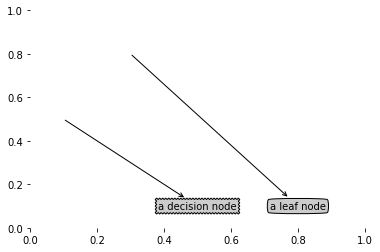

In [13]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth",fc="0.8")
leafNode = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.axl.annotate(nodeTxt,xy=parentPt,xycoords="axes fraction",xytext=centerPt,textcoords="axes fraction",
                           va="center",ha="center",bbox=nodeType,arrowprops=arrow_args)

def createPlot():
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.axl = plt.subplot(111,frameon=False)
    plotNode('a decision node',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('a leaf node',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()
    
createPlot()

In [22]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

#def createPlot():
#    fig = plt.figure(1, facecolor='white')
#    fig.clf()
#    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
#    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
#    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
#    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

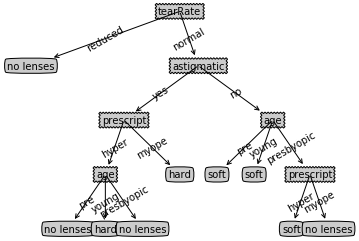

In [23]:
fr=open('./data/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
createPlot(lensesTree)